In [1]:
import cplex
import json
import numpy as np
import os
from scipy import sparse
import pandas as pd
from collections import namedtuple
from time import perf_counter
import swiglpk
import matplotlib.pyplot as plt

In [2]:
from mmodel import *
from optim import *

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

## Baisc analysis of models

In [5]:
recon2_model = make_unidirectional(read_model('RECON2_mat'))
recon3_model = make_unidirectional(read_model('RECON3_mat'))
mouse_gem_model = make_unidirectional(read_model('mouse_gem_mat'))

In [6]:
def sparsity(S):
    return S.nnz / (S.shape[0] * S.shape[1])

In [7]:
def characterize(model):
    print("Shape: ", model.S.shape)
    print("Entries: ", model.S.nnz)
    tmp = model.S.toarray() 
    #Test if a column is equal to a column of the identity matrix
    print("Number of exchange reactions: ", np.sum((np.abs(tmp).sum(axis=1) == 1) & (tmp.max(axis=1) == 1)))
    print("Matrix rank: ", np.linalg.matrix_rank(tmp))
    del(tmp)


In [98]:
def reversible_rxns(model):
    pos_rxns = {x[:-4] for x in model.rxns if x.endswith('_pos')}
    neg_rxns = {x[:-4] for x in model.rxns if x.endswith('_neg')}
    return len(pos_rxns & neg_rxns)

In [99]:
reversible_rxns(recon2_model)

3270

In [95]:
characterize(recon2_model)

Shape:  (10211, 5063)
Entries:  38560
Number of exchange reactions:  650
Matrix rank:  4470


In [100]:
reversible_rxns(recon3_model)

5403

In [96]:
characterize(recon3_model)

Shape:  (16003, 5835)
Entries:  54885
Number of exchange reactions:  1656
Matrix rank:  5739


In [101]:
reversible_rxns(mouse_gem_model)

6133

In [97]:
characterize(mouse_gem_model)

Shape:  (19189, 8370)
Entries:  73715
Number of exchange reactions:  1665
Matrix rank:  8091


In [11]:
rng = np.random.default_rng(seed=1337)
N_reactions = 10
selected_rxns = np.arange(10000)
rng.shuffle(selected_rxns)
selected_rxns = selected_rxns[:N_reactions]
selected_samples = rng.integers(290, size=N_reactions)

In [10]:
models = {
    'recon2':recon2_model,
    'recon3':recon3_model,
    'mouse_gem':mouse_gem_model
}

In [12]:
cplex_solvers = {
    0: 'Automatic',
    1: 'Primal Simplex',
    2: 'Dual Simplex',
    3: 'Network Simplex',
    4: 'Barrier',
    5: 'Sifting'
}

In [13]:
cplex_times_lp = {}
cplex_res_lp = {}
for model in models.keys():
    for lpmethod in cplex_solvers.keys():
        cplex_prob = make_cplex_prob(models[model])
        cplex_prob.parameters.lpmethod.set(lpmethod)
        cplex_solver = Cplex_Solver(cplex_prob, models[model], Cplex_Solver.simple_solver_fn)

        cplex_res_lp[(model, lpmethod)], cplex_times_lp[(model, lpmethod)] = cplex_solver.solve(selected_rxns, selected_samples)

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 2159 rows and 3873 columns.
Aggregator did 1158 substitutions.
Reduced LP has 1424 rows, 5180 columns, and 21143 nonzeros.
Presolve time = 0.03 sec. (16.34 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          5540.122983
Iteration:   106   Dual objective     =         14265.487968
Iteration:   188   Dual objective     =         15317.089676
Iteration:   270   Dual objective     =         15925.851244
Iteration:   343   Dual objective     =         16863.820867
Iteration:   415   Dual objective     =         17306.111491
Iteration:   482   Dual objective     =         17628.480706
Iteration:   550   Dual objective  

 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...

Iteration log . . .
Iteration:     1   Scaled dual infeas =           793.041186
Iteration:   509   Dual objective     =       -274406.658896
Iteration:   763   Dual objective     =        -70104.941336
Iteration:   919   Dual objective     =        -26861.167124
Iteration:  1103   Dual objective     =         -8033.559232
Iteration:  1280   Dual objective     =         -1875.332357
Iteration:  1416   Dual objective     =            22.111006
Iteration:  1538   Dual objective     =            39.499353
Iteration:  1659   Dual objective     =            47.468156

Barrier solved model.

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                1
Tried aggregator 1 time.
LP Presolve eliminated 2159 rows and 3873 columns.
Aggregator did 1158 substitutions.
Reduced LP has 1424 

Iteration:   401    Scaled infeas =           105.555556
Iteration:   561    Scaled infeas =           105.555556
Perturbation started.
Switched to devex.
Iteration:   601    Scaled infeas =           105.555556
Iteration:   736    Scaled infeas =           105.555547
Iteration:   915    Scaled infeas =            99.724320
Iteration:  1078    Objective     =         39975.542721
Iteration:  1345    Objective     =         27126.449810
Iteration:  1350    Objective     =         26141.565533
Iteration:  1584    Objective     =         25450.214490
Iteration:  1761    Objective     =         25206.894479
Iteration:  2009    Objective     =         24052.456792
Iteration:  2231    Objective     =         23883.731957
Iteration:  2444    Objective     =         23818.298284
Iteration:  2667    Objective     =         23691.215674
Removing perturbation.
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                

Iteration:  1647   Dual objective     =          5217.340436
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                2
Reinitializing dual norms . . .
Computed 1 new norms.

Iteration log . . .
Iteration:     1   Scaled dual infeas =          1465.426406
Iteration:   227   Dual objective     =       -105709.717351
Iteration:   400   Dual objective     =         -4851.074090
Iteration:   527   Dual objective     =          2285.164508
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                2
Reinitializing dual norms . . .
Computed 1 new norms.

Iteration log . . .
Iteration:     1   Scaled dual infeas =           407.886420
Iteration:   269   Dual objective     =       -139221.036285
Iteration:   488   Dual objective     =         -1867.764916
Iteration:   631   Dual objective     =         17

Iteration:  2903   Dual objective     =         19800.593759
Iteration:  3019   Dual objective     =         20018.814731
Iteration:  3136   Dual objective     =         20282.690182
Iteration:  3267   Dual objective     =         20533.012149
Iteration:  3381   Dual objective     =         20700.089335
Iteration:  3509   Dual objective     =         20905.825488
Iteration:  3628   Dual objective     =         21224.494093
Iteration:  3751   Dual objective     =         21325.517445
Iteration:  3863   Dual objective     =         21421.692748
Iteration:  3980   Dual objective     =         21505.669603
Iteration:  4097   Dual objective     =         21619.582619
Iteration:  4218   Dual objective     =         21838.942653
Iteration:  4341   Dual objective     =         21929.355615
Iteration:  4460   Dual objective     =         21996.050806
Iteration:  4589   Dual objective     =         22052.645044
Iteration:  4701   Dual objective     =         22098.245638
Iteration:  4847   Dual 

Iteration:  1073   Dual objective     =            61.266679
Iteration:  1188   Dual objective     =            62.902833
Iteration:  1302   Dual objective     =            64.659338
Iteration:  1427   Dual objective     =            65.758149
Iteration:  1545   Dual objective     =            66.877419
Iteration:  1678   Dual objective     =            67.878724
Iteration:  1803   Dual objective     =            68.577987
Iteration:  1907   Dual objective     =            68.892326
Iteration:  2024   Dual objective     =            69.318366
Iteration:  2126   Dual objective     =            69.354404
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
Tried aggregator 1 time.
LP Presolve eliminated 2160 rows and 3873 columns.
Aggregator did 1158 substitutions.
Reduced LP has 1423 rows, 5180 columns, and 21139 nonzeros.
Presolve time = 0.03 sec. (16.44 ticks)
Parallel mode: using up

CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
Tried aggregator 1 time.
LP Presolve eliminated 2157 rows and 3873 columns.
Aggregator did 1161 substitutions.
Reduced LP has 1423 rows, 5177 columns, and 21133 nonzeros.
Presolve time = 0.04 sec. (16.46 ticks)
Parallel mode: using up to 32 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 14212
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (3.53 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 32
  Rows in Factor            = 1423
  Integer space required    = 8208
  Total non-zeros in factor = 47687
  Total FP ops to factor    = 3511561
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf Inf Ratio
   0   2.2053211e+06  -1.4944090e+08  1.19e+06  3.32e+05  4.47e+03  1.00e+00
   1   1.8998402e+06  -4.1374675e+07  8.78e+05  2.45e+05  1.26e+03  2.45e-04
   2   1.2398311e+06  -1.3563562e+

   8   1.2103964e+05  -4.4734956e+05  5.90e+03  1.57e+03  1.85e+01  1.59e-02
   9   7.0597531e+04  -2.2024349e+05  1.84e+03  4.91e+02  1.00e+01  2.98e-02
  10   6.1879432e+04  -1.3409249e+05  1.24e+03  3.31e+02  6.75e+00  4.48e-02
  11   4.5137716e+04  -6.9249816e+04  4.23e+02  1.13e+02  4.19e+00  7.37e-02
  12   4.2254767e+04  -3.9036774e+04  3.38e+02  9.01e+01  2.92e+00  1.08e-01
  13   3.5776883e+04   4.0383873e+03  1.79e+02  4.76e+01  1.06e+00  3.16e-01
  14   3.1440460e+04   1.1446228e+04  1.12e+02  2.98e+01  6.70e-01  4.98e-01
  15   2.6203630e+04   1.6720493e+04  3.20e+01  8.53e+00  3.91e-01  8.55e-01
  16   2.5055793e+04   2.1020214e+04  1.30e+01  3.47e+00  1.68e-01  2.17e+00
  17   2.4296539e+04   2.2637561e+04  5.09e+00  1.36e+00  7.07e-02  5.41e+00
  18   2.3855544e+04   2.3122705e+04  1.23e+00  3.27e-01  3.89e-02  1.00e+01
  19   2.3726355e+04   2.3604510e+04  1.56e-01  4.16e-02  6.85e-03  7.00e+01
  20   2.3683820e+04   2.3673846e+04  4.87e-03  1.30e-03  7.56e-04  6.62e+02

  18   1.2151826e+03   1.2145615e+03  3.61e-02  9.65e-03  1.46e-06  1.38e+05
  19   1.2146008e+03   1.2146007e+03  8.15e-06  2.16e-06  2.16e-10  1.43e+08
  20   1.2146007e+03   1.2146007e+03  1.10e-08  7.25e-10  2.59e-12  6.16e+11
  21   1.2146007e+03   1.2146007e+03  4.47e-10  4.55e-10  2.40e-12  9.70e+13
Barrier time = 0.15 sec. (30.43 ticks)
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting primal Simplex on 1 thread...

Dual crossover.
  Dual:  Fixing 1247 variables.
     1246 DMoves:  Infeasibility  0.00000000e+00  Objective  1.21460072e+03
      845 DMoves:  Infeasibility  0.00000000e+00  Objective  1.21460072e+03
      347 DMoves:  Infeasibility  2.77555756e-17  Objective  1.21460072e+03
       20 DMoves:  Infeasibility  2.77555756e-17  Objective  1.21460072e+03
        0 DMoves:  Infeasibility  1.38777878e-16  Objective  1.21460072e+03
  Dual:  Pushed 619, exchanged 628.
  Primal:  Fixing 2 vari

CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
Tried aggregator 1 time.
LP Presolve eliminated 2156 rows and 3870 columns.
Aggregator did 1161 substitutions.
Reduced LP has 1423 rows, 5180 columns, and 21140 nonzeros.
Presolve time = 0.03 sec. (16.44 ticks)
Parallel mode: using up to 32 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 14213
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (3.53 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 32
  Rows in Factor            = 1423
  Integer space required    = 8158
  Total non-zeros in factor = 48295
  Total FP ops to factor    = 3650871
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf Inf Ratio
   0   1.9961872e+06  -1.3449358e+08  1.08e+06  2.88e+05  4.04e+03  1.00e+00
   1   1.6957518e+06  -3.8264611e+07  7.62e+05  2.03e+05  1.17e+03  3.15e-04
   2   1.2005351e+06  -1.1040779e+

Sifting iteration   14 [ 7998]:   Objective     =          5220.670808
Sifting iteration   15 [ 8008]:   Objective     =          5220.670813
Sifting iteration   16 [ 8012]:   Objective     =          5220.670805
Sifting iteration   17 [ 8014]:   Objective     =          5220.670808
Sifting iteration   18 [ 8016]:   Objective     =          5220.670808
Sifting iteration   19 [ 8021]:   Objective     =          5220.670809
Sifting iteration   20 [ 8025]:   Objective     =          5220.670806
Sifting iteration   21 [ 8028]:   Objective     =          5220.670808
Sifting iteration   22 [ 8030]:   Objective     =          5220.670808
Removing sifting perturbation
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                5

Iteration log . . .
Sifting iteration    1 [ 6076]:   Scaled infeas =             0.000000
Sifting iteration    2 [ 7076]:   Objective     =          2736.732530
Sifting iter

CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                5

Iteration log . . .
Sifting iteration    1 [ 6062]:   Scaled infeas =             4.257644
Sifting iteration    2 [ 6832]:   Scaled infeas =             0.000000
Sifting iteration    3 [ 7832]:   Objective     =            69.699236
Sifting iteration    4 [ 8147]:   Objective     =            69.361660
Sifting iteration    5 [ 8212]:   Objective     =            69.361660
Sifting perturbation started
Sifting iteration    6 [ 8244]:   Objective     =            69.358962
Sifting iteration    7 [ 8361]:   Objective     =            69.358555
Sifting iteration    8 [ 8405]:   Objective     =            69.359521
Sifting iteration    9 [ 8417]:   Objective     =            69.359637
Sifting iteration   10 [ 8428]:   Objective     =            69.359644
Sifting iteration   11 [ 8432]:   Objective     =            69.359644
Removing sifting perturbation
Version identifier: 22.1.0.0 | 2022-0

Presolve time = 0.04 sec. (35.42 ticks)

Iteration log . . .
Iteration:     1    Scaled infeas =             0.947813
Iteration:    21    Scaled infeas =             0.364219
Iteration:   215    Scaled infeas =             0.043895
Iteration:   402    Scaled infeas =             0.025884
Iteration:   570    Scaled infeas =             0.025938
Iteration:   747    Scaled infeas =             0.025938
Iteration:   914    Scaled infeas =             0.020625
Iteration:  1073    Scaled infeas =             0.020625
Iteration:  1251    Scaled infeas =             0.020625
Iteration:  1418    Scaled infeas =             0.010000
Iteration:  1583    Scaled infeas =             0.010000
Iteration:  1739    Scaled infeas =             0.010000
Iteration:  1901    Scaled infeas =             0.010000
Perturbation started.
Switched to devex.
Iteration:  2001    Scaled infeas =             0.009999
Iteration:  2040    Objective     =            10.959740
Iteration:  2175    Objective     =        

Iteration:  2327    Objective     =          1268.732328
Switched to steepest-edge.
Iteration:  2499    Objective     =          1268.732327
Removing perturbation.
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                1

Iteration log . . .
Iteration:     1    Scaled infeas =            35.150000
Iteration:   147    Scaled infeas =            35.150000
Switched to devex.
Iteration:   308    Objective     =           255.317021
Iteration:   553    Objective     =           180.303426
Iteration:   560    Objective     =           180.303426
Iteration:   752    Objective     =           136.066054
Iteration:   973    Objective     =           136.066054
Iteration:  1180    Objective     =           136.066054
Iteration:  1391    Objective     =           136.066054
Perturbation started.
Iteration:  1509    Objective     =           136.066054
Iteration:  1686    Objective     =           13


Iteration log . . .
Iteration:     1   Scaled dual infeas =           141.911796
Iteration:   281   Dual objective     =        -47685.312577
Iteration:   544   Dual objective     =         -1773.423696
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                2
Reinitializing dual norms . . .
Computed 2 new norms.

Iteration log . . .
Iteration:     1   Scaled dual infeas =           173.297632
Iteration:   253   Dual objective     =        -16851.277958
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                2
Reinitializing dual norms . . .
Computed 2 new norms.

Iteration log . . .
Iteration:     1   Scaled dual infeas =           242.528369
Iteration:   209   Dual objective     =        -31178.639319
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck             

   8   4.9957231e+05  -1.1589916e+06  2.47e+04  1.52e+04  5.08e+01  1.25e-02
   9   3.5913693e+05  -6.8344362e+05  1.69e+04  1.04e+04  3.08e+01  2.02e-02
  10   2.8985079e+05  -3.9678306e+05  1.36e+04  8.36e+03  1.80e+01  3.37e-02
  11   2.2082593e+05  -2.2607286e+05  1.04e+04  6.39e+03  1.02e+01  5.66e-02
  12   1.8741350e+05  -1.7506103e+05  8.96e+03  5.50e+03  7.69e+00  7.25e-02
  13   1.2159576e+05  -8.7814377e+04  5.95e+03  3.66e+03  3.65e+00  1.37e-01
  14   1.0737390e+05  -6.1912743e+04  5.30e+03  3.25e+03  2.47e+00  1.88e-01
  15   9.0748054e+04  -4.6282177e+04  4.56e+03  2.80e+03  1.71e+00  2.47e-01
  16   4.8596344e+04  -3.5681987e+04  2.56e+03  1.57e+03  1.26e+00  3.18e-01
  17   6.3041998e+03  -7.1049640e+03  4.00e+02  2.46e+02  2.06e-01  1.48e+00
  18   4.5016569e+02  -9.2455756e+02  2.84e+01  1.75e+01  2.69e-02  1.13e+01
  19   1.2792140e+02  -4.0441329e+02  5.37e+00  3.30e+00  1.26e-02  2.56e+01
  20   6.6503651e+01  -1.8192034e+02  1.65e+00  1.01e+00  6.28e-03  5.60e+01

  21   2.1888189e+03   2.1881443e+03  5.95e-04  3.65e-04  3.00e-05  3.00e+04
  22   2.1884843e+03   2.1884843e+03  6.49e-08  3.73e-08  3.66e-09  2.45e+08
  23   2.1884843e+03   2.1884843e+03  1.13e-10  1.50e-09  4.24e-12  2.69e+12
  24   2.1884843e+03   2.1884843e+03  1.68e-10  4.89e-10  3.16e-12  1.50e+16
Barrier time = 0.16 sec. (67.05 ticks)
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting primal Simplex on 1 thread...

Dual crossover.
  Dual:  Fixing 2263 variables.
     2262 DMoves:  Infeasibility  0.00000000e+00  Objective  2.18848431e+03
      919 DMoves:  Infeasibility  0.00000000e+00  Objective  2.18848431e+03
      228 DMoves:  Infeasibility  0.00000000e+00  Objective  2.18848431e+03
        0 DMoves:  Infeasibility  2.77555756e-16  Objective  2.18848431e+03
  Dual:  Pushed 1590, exchanged 673.
  Primal:  Fixed no variables.

Dual simplex solved model.

Total crossover time = 0.02 sec. (15.23

Presolve time = 0.07 sec. (53.61 ticks)
Parallel mode: using up to 32 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 26331
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (8.27 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 32
  Rows in Factor            = 2617
  Integer space required    = 16505
  Total non-zeros in factor = 89445
  Total FP ops to factor    = 7720049
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf Inf Ratio
   0   7.8697902e+06  -4.7857823e+08  3.67e+06  2.26e+06  1.52e+04  1.00e+00
   1   7.0736231e+06  -2.0373521e+08  2.98e+06  1.83e+06  6.54e+03  1.89e-04
   2   4.4438245e+06  -6.3640355e+07  9.15e+05  5.62e+05  2.11e+03  4.85e-04
   3   3.3804902e+06  -2.6712966e+07  3.90e+05  2.40e+05  9.35e+02  1.01e-03
   4   2.2472235e+06  -8.7891712e+06  1.55e+05  9.53e+04  3.41e+02  2.04e-03
   5   1.5183098e+06  -4.2384834e+06  9.04e+04  5.56e+04  1.74e+02  3.83e-0

  11   1.7286430e+05  -2.5286984e+05  8.30e+03  5.34e+03  1.10e+01  5.13e-02
  12   1.0436204e+05  -1.9051063e+05  4.92e+03  3.16e+03  8.31e+00  6.70e-02
  13   7.5085296e+04  -1.1761195e+05  3.39e+03  2.18e+03  5.29e+00  1.05e-01
  14   4.7601339e+04  -6.7671368e+04  2.06e+03  1.32e+03  3.14e+00  1.76e-01
  15   4.3069823e+04  -5.6795446e+04  1.87e+03  1.20e+03  2.63e+00  2.09e-01
  16   3.9071233e+04  -4.6324945e+04  1.69e+03  1.09e+03  2.16e+00  2.54e-01
  17   9.6358313e+03  -1.1060210e+04  4.14e+02  2.66e+02  5.17e-01  9.90e-01
  18   9.7078301e+02  -1.3346466e+03  4.16e+01  2.67e+01  6.25e-02  8.18e+00
  19   1.3623731e+02  -1.4169271e+02  5.01e+00  3.22e+00  7.54e-03  7.08e+01
  20   1.7040859e+01  -1.5523235e-01  5.41e-01  3.47e-01  1.46e-04  3.66e+03
  21   2.6409000e+00   2.6359600e+00  1.64e-04  1.06e-04  2.91e-08  5.62e+06
  22   2.6377764e+00   2.6377758e+00  2.81e-08  1.48e-08  6.39e-12  3.90e+10
  23   2.6377761e+00   2.6377761e+00  6.41e-09  1.09e-09  3.10e-12  3.21e+14

 * Starting dual Simplex on 1 thread...
 * Starting primal Simplex on 1 thread...

Dual crossover.
  Dual:  Fixing 2283 variables.
     2282 DMoves:  Infeasibility  0.00000000e+00  Objective  3.17160207e+03
      777 DMoves:  Infeasibility  6.66133815e-16  Objective  3.17160207e+03
      140 DMoves:  Infeasibility  2.22044605e-16  Objective  3.17160207e+03
        0 DMoves:  Infeasibility  5.55111512e-16  Objective  3.17160207e+03
  Dual:  Pushed 1641, exchanged 642.
  Primal:  Fixed no variables.

Dual simplex solved model.

Total crossover time = 0.03 sec. (14.66 ticks)

Total time on 32 threads = 0.29 sec. (133.40 ticks)
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                5
Tried aggregator 1 time.
LP Presolve eliminated 619 rows and 4240 columns.
Aggregator did 1515 substitutions.
Reduced LP has 2618 rows, 10248 columns, and 39916 nonzeros.
Presolve time = 0.06 sec. (35.27 ticks)



Sifting iteration   35 [12711]:   Objective     =          2188.481331
Sifting iteration   36 [12712]:   Objective     =          2188.481338
Sifting iteration   37 [12714]:   Objective     =          2188.481325
Sifting iteration   38 [12715]:   Objective     =          2188.481328
Sifting iteration   39 [12716]:   Objective     =          2188.481340
Removing sifting perturbation
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                5

Iteration log . . .
Sifting iteration    1 [ 7973]:   Scaled infeas =             0.000000
Sifting iteration    2 [ 8973]:   Objective     =          1325.103251
Sifting iteration    3 [ 9973]:   Objective     =          1325.103251
Sifting iteration    4 [10973]:   Objective     =          1325.103251
Sifting perturbation started
Sifting iteration    5 [11449]:   Objective     =          1325.100414
Sifting iteration    6 [11889]:   Objective     =     

Sifting iteration    3 [ 9507]:   Objective     =           136.386284
Sifting iteration    4 [10507]:   Objective     =           136.386284
Sifting iteration    5 [11101]:   Objective     =           136.066054
Sifting iteration    6 [11322]:   Objective     =           136.066054
Sifting iteration    7 [11416]:   Objective     =           136.066054
Sifting perturbation started
Sifting iteration    8 [11463]:   Objective     =            -0.000133
Sifting iteration    9 [12402]:   Scaled infeas =             0.000001
Sifting iteration   10 [13402]:   Scaled infeas =            -0.000001
Sifting iteration   11 [14397]:   Scaled infeas =            -0.000000
Sifting iteration   12 [14653]:   Objective     =           136.066026
Sifting iteration   13 [14764]:   Objective     =           136.066025
Sifting iteration   14 [14819]:   Objective     =           136.066049
Sifting iteration   15 [14859]:   Objective     =           136.066037
Sifting iteration   16 [14886]:   Objective     

 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...

Iteration log . . .
Iteration:     1   Scaled dual infeas =            34.854483
Iteration:    64   Dual objective     =         -2512.670632

Dual simplex solved model.

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...

Iteration log . . .
Iteration:     1   Scaled dual infeas =            42.869319
Iteration:    89   Dual objective     =        -16941.916826
Iteration:   316   Dual objective     =            22.465174
Iteration:   464   Dual objective     =            24.544506
Iteration:   607   Dual objective     =            25.699618
Iteration:   746   Dual objective     =            26.291829
Iteration:   880

Iteration:  3889   Dual objective     =         -6030.049835
Iteration:  4081   Dual objective     =         -1026.541115
Iteration:  4283   Dual objective     =          1625.240951
Iteration:  4435   Dual objective     =          1910.564355
Iteration:  4558   Dual objective     =          1961.865323

Barrier solved model.

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...

Iteration log . . .
Iteration:     1   Scaled dual infeas =          6508.855540
Iteration:   931   Dual objective     =       -641411.547878
Iteration:  1311   Dual objective     =       -268673.117571
Iteration:  1665   Dual objective     =       -160043.608477
Iteration:  1953   Dual objective     =        -95753.128606
Iteration:  2271   Dual objective     =

Markowitz threshold set to 0.1


Iteration:   940    Scaled infeas =             0.000492
Iteration:   944    Scaled infeas =             0.000492
Iteration:   948    Scaled infeas =             0.000490
Iteration:   958    Scaled infeas =             0.000485
Iteration:   997    Objective     =            86.868641
Iteration:  1269    Objective     =            36.375097
Iteration:  1271    Objective     =            32.441686
Iteration:  1542    Objective     =            28.675959
Iteration:  1738    Objective     =            28.675884
Iteration:  1923    Objective     =            28.675822
Iteration:  2121    Objective     =            28.675769
Iteration:  2303    Objective     =            28.675729
Iteration:  2493    Objective     =            28.450239
Switched to steepest-edge.
Iteration:  2679    Objective     =            28.450198
Iteration:  2800    Objective     =            28.450157
Iteration:  2940    Objective     =            28.450127
Iteration:  3075    Objective     =            28.450085
Iter

Markowitz threshold set to 0.1


Iteration:   857    Scaled infeas =             0.048546
Iteration:   873    Scaled infeas =             0.001259
Iteration:   878    Scaled infeas =             0.001259
Iteration:   882    Scaled infeas =             0.001259
Iteration:   916    Scaled infeas =             0.000208
Iteration:   949    Scaled infeas =             0.000199
Iteration:   960    Scaled infeas =             0.000175
Iteration:  1039    Objective     =           426.676068
Iteration:  1271    Objective     =           185.430779
Iteration:  1282    Objective     =           169.038985
Iteration:  1539    Objective     =           166.536352
Iteration:  1807    Objective     =           135.655555
Iteration:  2096    Objective     =           133.390640
Iteration:  2338    Objective     =           119.266914
Iteration:  2568    Objective     =           119.266339
Iteration:  2832    Objective     =           119.266165
Iteration:  3058    Objective     =           119.219043
Iteration:  3277    Objective  

Iteration:  8268    Objective     =          5521.807832
Perturbation started.
Switched to steepest-edge.
Iteration:  8395    Objective     =          5521.807832
Removing perturbation.
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                1

Iteration log . . .
Iteration:     1    Scaled infeas =           160.060277
Iteration:     6    Scaled infeas =           160.060277
Iteration:   196    Scaled infeas =           160.060277
Iteration:   395    Scaled infeas =           160.060277
Iteration:   608    Scaled infeas =           160.060277
Perturbation started.
Switched to devex.
Iteration:   701    Scaled infeas =           160.060277
Iteration:   949    Scaled infeas =            19.115890
Iteration:  1174    Scaled infeas =             1.273922
Iteration:  1243    Objective     =          7410.761533
Iteration:  1503    Objective     =          4044.416220
Iteration:  1508    Object

Iteration:    64   Dual objective     =         -2512.670632
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                2
Reinitializing dual norms . . .
Computed 4 new norms.

Iteration log . . .
Iteration:     1   Scaled dual infeas =            44.513831
Iteration:   124   Dual objective     =        -29804.698219
Iteration:   399   Dual objective     =            21.731903
Iteration:   545   Dual objective     =            23.629199
Iteration:   689   Dual objective     =            25.120444
Iteration:   830   Dual objective     =            26.101925
Iteration:   970   Dual objective     =            26.874729
Iteration:  1104   Dual objective     =            27.513659
Iteration:  1256   Dual objective     =            27.991828
Iteration:  1403   Dual objective     =            28.211843
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                     

CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                2
Reinitializing dual norms . . .
Computed 17 new norms.

Iteration log . . .
Iteration:     1   Scaled dual infeas =        106259.378281
Iteration:  1718   Dual objective     =     -47733657.413790
Iteration:  1956   Dual objective     =      -1774902.765644
Iteration:  2316   Dual objective     =      -1249023.095687
Iteration:  2617   Dual objective     =       -826171.922153
Iteration:  2988   Dual objective     =       -684689.864368
Iteration:  3283   Dual objective     =       -308686.953501
Iteration:  3535   Dual objective     =       -277330.385850
Iteration:  3874   Dual objective     =       -213067.592563
Iteration:  4170   Dual objective     =       -170369.015891
Iteration:  4427   Dual objective     =       -120785.530721
Iteration:  4667   Dual objective     =        -96033.301723
Iteration:  4928   Dual objective     =        -64885.657547
Iteration:  5137   Dual objec

Iteration:  3082   Dual objective     =           108.117202
Iteration:  3210   Dual objective     =           108.434953
Iteration:  3365   Dual objective     =           108.491225
Iteration:  3498   Dual objective     =           108.549740
Iteration:  3630   Dual objective     =           108.603027
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Extracted network with 6834 nodes and 16763 arcs.
Extraction time = 0.01 sec. (2.08 ticks)

Iteration log . . .
Iteration:     0   Infeasibility     =             1.900000 (1.9)

Network - Optimal:  Objective =    1.6418221933e+01
Network time = 0.01 sec. (1.00 ticks)  Iterations = 36 (32)

Iteration log . . .
Iteration:     1   Dual objective     =            17.342541
Iteration:   201   Dual objective     =            54.080919
Iteration:   407   Dual objective     =            71.355578
Iteration:   586   Dual objective     =     

Iteration:   614   Dual objective     =          1763.123641
Iteration:   747   Dual objective     =          1841.880968
Iteration:   907   Dual objective     =          1917.153028
Iteration:  1018   Dual objective     =          1936.974229
Iteration:  1140   Dual objective     =          1961.329643
Iteration:  1262   Dual objective     =          1978.795004
Iteration:  1396   Dual objective     =          1986.645605
Iteration:  1528   Dual objective     =          1993.322406
Iteration:  1656   Dual objective     =          1999.553360
Iteration:  1805   Dual objective     =          2005.196230
Iteration:  1931   Dual objective     =          2011.780067
Iteration:  2050   Dual objective     =          2013.817957
Iteration:  2176   Dual objective     =          2016.627285
Iteration:  2300   Dual objective     =          2021.030397
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                        

  37   6.4164681e+04  -1.7390911e+04  1.57e+03  3.29e+03  1.64e-02  8.36e-01
  38   6.3778518e+04  -1.7170464e+04  1.56e+03  3.27e+03  1.63e-02  8.31e-01
  39   6.2561374e+04  -1.6237283e+04  1.53e+03  3.22e+03  1.24e-02  1.01e+00
  40   6.0656134e+04  -1.4298851e+04  1.49e+03  3.12e+03  1.05e-02  1.04e+00
  41   5.9631676e+04  -1.4230030e+04  1.47e+03  3.08e+03  8.39e-03  1.24e+00
  42   5.6737679e+04  -1.1810774e+04  1.41e+03  2.95e+03  5.89e-03  1.30e+00
  43   5.3073968e+04  -1.1652579e+04  1.33e+03  2.78e+03  5.61e-03  1.33e+00
  44   4.9131408e+04  -1.0772530e+04  1.24e+03  2.60e+03  4.54e-03  1.41e+00
  45   4.6842050e+04  -9.1267135e+03  1.19e+03  2.49e+03  2.37e-03  1.77e+00
  46   3.9117474e+04  -8.3520522e+03  1.01e+03  2.13e+03  1.85e-03  1.76e+00
  47   3.8351083e+04  -7.7385050e+03  9.96e+02  2.09e+03  1.49e-03  1.86e+00
  48   3.7332860e+04  -7.6760646e+03  9.74e+02  2.04e+03  1.33e-03  2.02e+00
  49   3.4094483e+04  -7.1033777e+03  8.98e+02  1.88e+03  1.11e-03  1.99e+00

  44   1.3561802e+04  -1.6410545e+03  3.44e+02  8.87e+01  1.60e-02  3.75e+00
  45   1.2573259e+04  -4.9861065e+02  3.19e+02  8.22e+01  5.30e-03  6.46e+00
  46   9.8604758e+03   2.8407328e+02  2.46e+02  6.33e+01  2.06e-03  7.23e+00
  47   9.0241642e+03   4.5089835e+02  2.21e+02  5.68e+01  1.81e-03  6.98e+00
  48   8.5074853e+03   4.9406134e+02  2.07e+02  5.33e+01  1.57e-03  8.25e+00
  49   7.1005384e+03   5.9891088e+02  1.65e+02  4.26e+01  1.40e-03  8.16e+00
  50   6.7209364e+03   8.6070943e+02  1.54e+02  3.96e+01  1.07e-03  9.28e+00
  51   3.8272429e+03   1.8193364e+03  5.92e+01  1.52e+01  1.84e-04  3.18e+01
  52   2.2926828e+03   2.1738104e+03  3.60e+00  9.28e-01  9.55e-06  6.09e+02
  53   2.1986396e+03   2.1926779e+03  1.81e-01  4.65e-02  4.79e-07  1.21e+04
  54   2.1939358e+03   2.1936272e+03  9.41e-03  2.42e-03  2.41e-08  2.40e+05
  55   2.1936906e+03   2.1936750e+03  4.78e-04  1.23e-04  1.29e-09  4.77e+06
  56   2.1936782e+03   2.1936774e+03  2.40e-05  6.17e-06  1.30e-10  9.48e+07

  66   2.8273482e+01   2.7786976e+01  2.26e-02  4.61e-03  2.36e-08  2.83e+04
  67   2.8321667e+01   2.7844994e+01  2.27e-02  4.50e-03  2.30e-08  2.66e+04
  68   2.8284854e+01   2.7842526e+01  2.11e-02  4.18e-03  2.17e-08  3.04e+04
  69   2.8210807e+01   2.7943544e+01  1.43e-02  2.86e-03  1.12e-08  8.20e+04
  70   2.8238591e+01   2.8011525e+01  1.13e-02  1.82e-03  9.06e-09  9.10e+04
  71   2.8239853e+01   2.8024422e+01  1.07e-02  1.70e-03  8.56e-09  9.54e+04
  72   2.8244230e+01   2.8167829e+01  7.95e-03  1.19e-03  3.32e-09  2.27e+05
  73   2.8246396e+01   2.8241337e+01  1.37e-03  1.77e-04  4.46e-10  2.66e+06
  74   2.8248235e+01   2.8248064e+01  2.10e-04  1.62e-05  2.30e-10  5.01e+07
  75   2.8248276e+01   2.8248174e+01  1.38e-03  1.27e-05  2.91e-10  7.14e+07
  76   2.8248423e+01   2.8248418e+01  6.99e-05  6.42e-07  1.92e-10  1.40e+09
  77   2.8248431e+01   2.8248431e+01  3.51e-06  3.24e-08  1.88e-10  2.76e+10
  78   2.8248431e+01   2.8248431e+01  1.85e-07  2.98e-09  2.00e-10  5.44e+11

  68   1.0854261e+02   1.0845235e+02  1.13e-02  1.01e-03  1.45e-09  3.40e+05
  69   1.0854762e+02   1.0845411e+02  1.44e-02  1.01e-03  1.45e-09  3.17e+05
  70   1.0855137e+02   1.0845546e+02  1.78e-02  1.03e-03  1.47e-09  3.01e+05
  71   1.0855581e+02   1.0845752e+02  1.98e-02  1.03e-03  1.48e-09  2.86e+05
  72   1.0855666e+02   1.0845989e+02  2.00e-02  1.03e-03  1.48e-09  2.84e+05
  73   1.0856082e+02   1.0846323e+02  2.01e-02  1.03e-03  1.47e-09  2.75e+05
  74   1.0856085e+02   1.0846326e+02  2.00e-02  1.03e-03  1.48e-09  2.75e+05
  75   1.0856215e+02   1.0846350e+02  1.99e-02  1.02e-03  1.49e-09  2.74e+05
  76   1.0856559e+02   1.0846590e+02  2.09e-02  1.02e-03  1.50e-09  2.67e+05
  77   1.0856673e+02   1.0846693e+02  2.23e-02  1.02e-03  1.53e-09  2.66e+05
  78   1.0856902e+02   1.0846806e+02  2.36e-02  1.02e-03  1.53e-09  2.60e+05
  79   1.0856940e+02   1.0846864e+02  2.34e-02  1.02e-03  1.51e-09  2.59e+05
  80   1.0857279e+02   1.0847060e+02  2.50e-02  1.03e-03  1.53e-09  2.48e+05

  58   1.1655528e+02   1.0199213e+02  4.00e-01  1.03e-01  5.24e-06  2.02e+03
  59   1.1728365e+02   1.0245026e+02  4.07e-01  1.05e-01  5.33e-06  1.81e+03
  60   1.1854811e+02   1.0289344e+02  4.14e-01  1.07e-01  5.37e-06  1.54e+03
  61   1.1867483e+02   1.0331022e+02  4.15e-01  1.07e-01  5.38e-06  1.52e+03
  62   1.1906754e+02   1.0347585e+02  4.03e-01  1.04e-01  5.35e-06  1.43e+03
  63   1.1873310e+02   1.0432306e+02  3.87e-01  9.98e-02  4.74e-06  1.64e+03
  64   1.1853040e+02   1.0499677e+02  3.53e-01  9.12e-02  4.47e-06  1.66e+03
  65   1.1806005e+02   1.0543555e+02  3.26e-01  8.42e-02  4.21e-06  1.76e+03
  66   1.1829869e+02   1.0535296e+02  3.35e-01  8.65e-02  4.30e-06  1.65e+03
  67   1.1846995e+02   1.0610175e+02  3.04e-01  7.84e-02  4.08e-06  1.51e+03
  68   1.1842050e+02   1.0646872e+02  2.92e-01  7.54e-02  3.95e-06  1.54e+03
  69   1.1795075e+02   1.0799742e+02  2.69e-01  6.94e-02  2.94e-06  2.23e+03
  70   1.1798249e+02   1.0813355e+02  2.65e-01  6.83e-02  2.91e-06  2.13e+03

  29   7.7880986e+04  -2.5323174e+04  1.78e+03  4.58e+02  1.16e-01  5.38e-01
  30   6.7343109e+04  -1.6590139e+04  1.56e+03  4.02e+02  5.52e-02  8.31e-01
  31   5.6464239e+04  -1.6142344e+04  1.31e+03  3.39e+02  5.36e-02  7.78e-01
  32   5.5965488e+04  -1.5499993e+04  1.30e+03  3.36e+02  5.15e-02  7.82e-01
  33   5.4745152e+04  -1.4386372e+04  1.28e+03  3.29e+02  4.46e-02  8.62e-01
  34   5.4692536e+04  -1.4170566e+04  1.28e+03  3.29e+02  4.43e-02  8.57e-01
  35   4.9913175e+04  -1.3514740e+04  1.18e+03  3.04e+02  3.95e-02  9.36e-01
  36   3.8679629e+04  -1.2674647e+04  9.42e+02  2.43e+02  3.51e-02  1.01e+00
  37   3.8276532e+04  -1.2425807e+04  9.32e+02  2.40e+02  3.44e-02  9.98e-01
  38   3.5256897e+04  -1.2076404e+04  8.65e+02  2.23e+02  3.30e-02  1.02e+00
  39   3.3118651e+04  -7.7953421e+03  8.17e+02  2.11e+02  1.63e-02  1.69e+00
  40   3.2314131e+04  -6.8031315e+03  7.99e+02  2.06e+02  1.34e-02  1.78e+00
  41   2.4410931e+04  -6.4539339e+03  6.25e+02  1.61e+02  1.17e-02  1.88e+00

  15   6.4491135e+05  -2.5939618e+05  1.43e+04  3.70e+03  4.14e+00  5.11e-02
  16   4.6946802e+05  -2.1090644e+05  1.07e+04  2.76e+03  3.20e+00  6.28e-02
  17   2.9368956e+05  -1.5588132e+05  6.95e+03  1.79e+03  2.22e+00  8.41e-02
  18   2.2184677e+05  -1.2542106e+05  5.34e+03  1.38e+03  1.73e+00  1.02e-01
  19   2.0060451e+05  -1.1562825e+05  4.85e+03  1.25e+03  1.59e+00  1.09e-01
  20   1.6978020e+05  -1.0266711e+05  4.12e+03  1.06e+03  1.40e+00  1.21e-01
  21   1.5048828e+05  -9.6914874e+04  3.66e+03  9.44e+02  1.32e+00  1.32e-01
  22   1.3852545e+05  -8.9366088e+04  3.38e+03  8.72e+02  1.21e+00  1.40e-01
  23   1.3668374e+05  -8.7180475e+04  3.34e+03  8.61e+02  1.18e+00  1.42e-01
  24   1.3498710e+05  -6.8981605e+04  3.30e+03  8.50e+02  9.31e-01  1.81e-01
  25   1.2188473e+05  -6.2563293e+04  2.98e+03  7.68e+02  8.43e-01  1.93e-01
  26   1.1847930e+05  -5.9731726e+04  2.90e+03  7.47e+02  8.03e-01  2.05e-01
  27   1.1440396e+05  -4.4104093e+04  2.80e+03  7.22e+02  5.80e-01  2.77e-01

   4   2.8524512e+07  -2.2655834e+07  5.87e+05  1.51e+05  9.23e+02  9.60e-04
   5   1.4850425e+07  -1.0258660e+07  3.08e+05  7.94e+04  4.12e+02  1.99e-03
   6   6.6749095e+06  -6.3662071e+06  1.45e+05  3.74e+04  2.46e+02  3.06e-03
   7   3.8735170e+06  -3.6008979e+06  8.60e+04  2.22e+04  1.36e+02  4.92e-03
   8   2.6126479e+06  -2.2510686e+06  5.86e+04  1.51e+04  8.35e+01  7.36e-03
   9   2.0468574e+06  -1.5502893e+06  4.65e+04  1.20e+04  5.59e+01  1.01e-02
  10   1.3442884e+06  -1.0671019e+06  3.14e+04  8.09e+03  3.71e+01  1.41e-02
  11   1.1400544e+06  -7.7239566e+05  2.69e+04  6.92e+03  2.61e+01  1.89e-02
  12   9.8064616e+05  -5.9778653e+05  2.34e+04  6.03e+03  1.94e+01  2.40e-02
  13   7.2635525e+05  -4.2093947e+05  1.77e+04  4.56e+03  1.30e+01  3.30e-02
  14   4.8173283e+05  -2.9895981e+05  1.22e+04  3.14e+03  8.63e+00  4.55e-02
  15   3.5975406e+05  -2.1152907e+05  9.23e+03  2.38e+03  5.88e+00  6.27e-02
  16   3.2123795e+05  -1.8004988e+05  8.31e+03  2.14e+03  4.89e+00  7.32e-02

  26   6.9143622e+04  -3.1318956e+04  1.58e+03  4.06e+02  4.12e-01  3.69e-01
  27   6.1521979e+04  -2.8353767e+04  1.41e+03  3.64e+02  3.67e-01  4.15e-01
  28   6.0404748e+04  -2.4814759e+04  1.39e+03  3.57e+02  3.23e-01  4.64e-01
  29   5.9766249e+04  -2.2591454e+04  1.37e+03  3.54e+02  2.93e-01  5.04e-01
  30   5.8831523e+04  -1.9790139e+04  1.35e+03  3.48e+02  2.49e-01  5.87e-01
  31   5.5731496e+04  -1.6844783e+04  1.28e+03  3.30e+02  2.14e-01  6.43e-01
  32   4.9415507e+04  -1.4768696e+04  1.14e+03  2.95e+02  1.80e-01  7.68e-01
  33   4.5165798e+04  -9.9731155e+03  1.05e+03  2.70e+02  1.18e-01  1.01e+00
  34   3.9389010e+04  -8.9684592e+03  9.17e+02  2.36e+02  1.04e-01  1.07e+00
  35   3.7810673e+04  -6.8860841e+03  8.81e+02  2.27e+02  7.58e-02  1.30e+00
  36   3.5399697e+04  -5.9583656e+03  8.25e+02  2.13e+02  6.51e-02  1.42e+00
  37   3.3764687e+04  -5.1545177e+03  7.88e+02  2.03e+02  5.52e-02  1.57e+00
  38   3.0403995e+04  -4.0924141e+03  7.10e+02  1.83e+02  4.32e-02  1.74e+00

  45   1.8388340e+04  -4.1283378e+03  5.36e+02  1.38e+02  5.22e-03  3.10e+00
  46   1.5773122e+04  -4.0318525e+03  4.71e+02  1.21e+02  4.72e-03  3.37e+00
  47   1.0247877e+04  -2.6757482e+03  3.25e+02  8.39e+01  1.41e-03  4.75e+00
  48   8.2870373e+03  -2.3282647e+03  2.70e+02  6.96e+01  1.06e-03  5.16e+00
  49   6.6635590e+03  -2.0355227e+03  2.21e+02  5.69e+01  8.74e-04  5.30e+00
  50   6.0246976e+03  -1.8282864e+03  2.02e+02  5.20e+01  7.34e-04  6.57e+00
  51   5.0494620e+03  -1.5673558e+03  1.72e+02  4.43e+01  5.87e-04  7.30e+00
  52   4.2218796e+03  -1.2382498e+03  1.45e+02  3.74e+01  4.35e-04  8.61e+00
  53   2.0639639e+03  -6.9923385e+02  7.00e+01  1.80e+01  2.54e-04  1.36e+01
  54   9.1795478e+02  -3.4261388e+02  3.01e+01  7.75e+00  1.34e-04  2.20e+01
  55   7.5776242e+02  -1.8701574e+02  2.37e+01  6.11e+00  9.23e-05  3.06e+01
  56   4.8367719e+02  -2.8945406e+01  1.28e+01  3.31e+00  5.03e-05  5.11e+01
  57   3.0692834e+02   1.0165101e+02  5.05e+00  1.30e+00  2.06e-05  1.21e+02

CPXPARAM_LPMethod                                5

Iteration log . . .
Sifting iteration    1 [11153]:   Scaled infeas =             4.620455
Sifting iteration    2 [12153]:   Scaled infeas =             0.000000
Sifting iteration    3 [13153]:   Objective     =            34.511771
Sifting iteration    4 [14153]:   Objective     =            29.859766
Sifting iteration    5 [14629]:   Objective     =            28.248431
Sifting iteration    6 [14795]:   Objective     =            28.248431
Sifting iteration    7 [14877]:   Objective     =            28.248432
Sifting perturbation started
Sifting iteration    8 [15212]:   Objective     =            28.156271
Sifting iteration    9 [15284]:   Objective     =            28.156048
Sifting iteration   10 [15419]:   Objective     =            28.156610
Sifting iteration   11 [15454]:   Objective     =            28.156599
Sifting iteration   12 [15455]:   Objective     =            28.156599
Removing sifting perturbation
Version identifie

Sifting iteration   15 [15365]:   Objective     =          2022.896657
Sifting iteration   16 [15393]:   Objective     =          2022.896685
Sifting iteration   17 [15409]:   Objective     =          2022.896689
Sifting iteration   18 [15412]:   Objective     =          2022.896689
Removing sifting perturbation
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                5

Iteration log . . .
Sifting iteration    1 [ 9693]:   Scaled infeas =           950.000000
Sifting iteration    2 [ 9927]:   Scaled infeas =           450.000000
Sifting iteration    3 [10139]:   Scaled infeas =             0.000000
Sifting iteration    4 [10941]:   Objective     =          3573.458731
Sifting iteration    5 [11941]:   Objective     =          3573.458869
Sifting iteration    6 [12941]:   Objective     =          3573.458853
Sifting iteration    7 [13731]:   Objective     =          3573.458852
Sifting iter

In [21]:
mouse_gem_times = {cplex_solvers[k[1]]:np.mean(cplex_times_lp[k]) for k in cplex_times_lp if k[0]=='mouse_gem'}

Text(0, 0.5, 'Runtime in seconds')

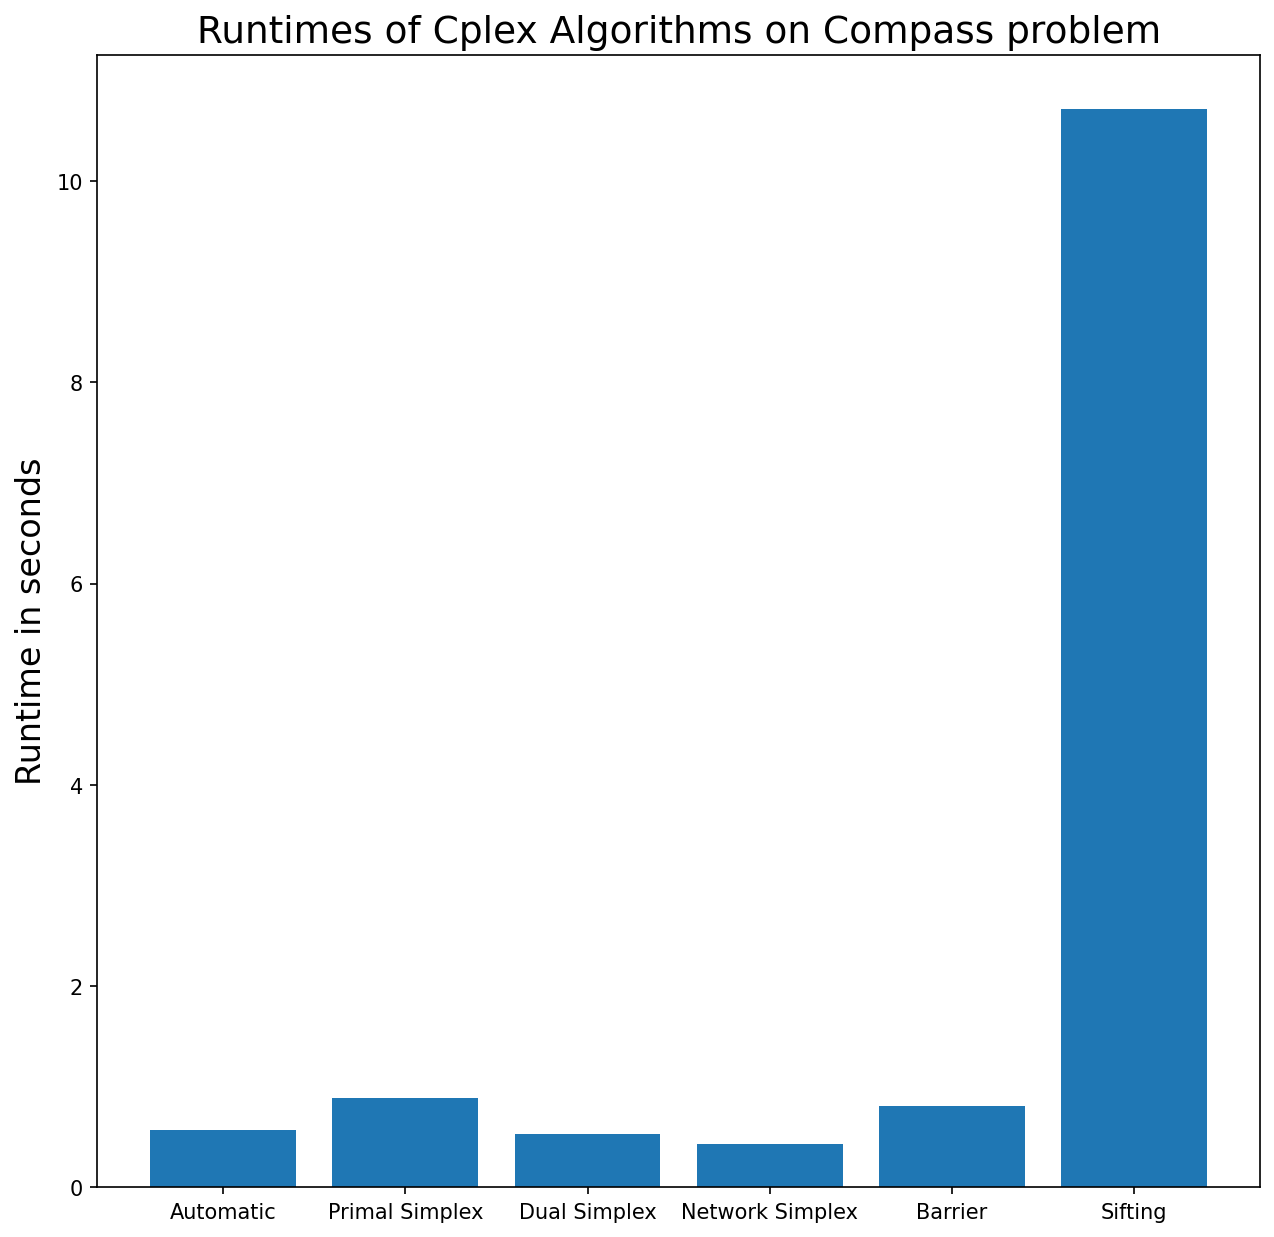

In [38]:
fig, axs = plt.subplots(figsize=(10,10), dpi=150)
plt.bar(list(mouse_gem_times.keys()), list(mouse_gem_times.values()))
axs.set_title("Runtimes of Cplex Algorithms on Compass problem", size=18)
axs.set_ylabel('Runtime in seconds', size=16)

In [18]:
parm = swiglpk.glp_smcp()
swiglpk.glp_init_smcp(parm)
parm.presolve = swiglpk.GLP_ON
def parm_simplex_solver_fn(lp, cache):
    swiglpk.glp_simplex(lp, parm)
    return swiglpk.glp_get_obj_val(lp), None

In [ ]:
glpk_times = {}
glpk_res = {}
for model in models.keys():
    glpk_prob = make_glpk_problem(models[model])
    glpk_solver = Glpk_Solver(glpk_prob, models[model], parm_simplex_solver_fn)
    glpk_res[model], glpk_times[model] = glpk_solver.solve(selected_rxns, selected_samples)

GLPK Simplex Optimizer 5.0
5063 rows, 10211 columns, 38560 non-zeros
Preprocessing...
4152 rows, 8930 columns, 35134 non-zeros
Scaling...
 A: min|aij| =  2.914e-03  max|aij| =  2.070e+01  ratio =  7.105e+03
GM: min|aij| =  1.090e-01  max|aij| =  9.175e+00  ratio =  8.418e+01
EQ: min|aij| =  1.188e-02  max|aij| =  1.000e+00  ratio =  8.418e+01
Constructing initial basis...
Size of triangular part is 3448
*     0: obj =   1.900000000e+03 inf =   0.000e+00 (1182)
Perturbing LP to avoid stalling [225]...
Removing LP perturbation [927]...
*   927: obj =   1.900000000e+03 inf =   0.000e+00 (0) 5
OPTIMAL LP SOLUTION FOUND
GLPK Simplex Optimizer 5.0
5063 rows, 10211 columns, 38560 non-zeros
Preprocessing...
4151 rows, 8927 columns, 35118 non-zeros
Scaling...
 A: min|aij| =  2.914e-03  max|aij| =  2.070e+01  ratio =  7.105e+03
GM: min|aij| =  1.090e-01  max|aij| =  9.175e+00  ratio =  8.418e+01
EQ: min|aij| =  1.188e-02  max|aij| =  1.000e+00  ratio =  8.418e+01
Constructing initial basis...
Si

In [ ]:
parm = swiglpk.glp_smcp()
swiglpk.glp_init_smcp(parm)
parm.presolve = swiglpk.GLP_ON
def warm_start_simplex_solver_fn(lp, cache):
    if cache:
        row_cache, col_cache = cache
        for i in range(len(row_cache)):
            swiglpk.glp_set_row_stat(lp, i+1, row_cache[i])
        for j in range(len(col_cache)):
            swiglpk.glp_set_col_stat(lp, j+1, col_cache[j])
    
    swiglpk.glp_simplex(lp, parm)
    
    row_cache, col_cache = [0] * swiglpk.glp_get_num_rows(lp), [0] * swiglpk.glp_get_num_cols(lp)
    for i in range(len(row_cache)):
        row_cache[i] = swiglpk.glp_get_row_stat(lp, i+1)
    for j in range(len(col_cache)):
        col_cache[j] = swiglpk.glp_get_col_stat(lp, j+1)
        
    return swiglpk.glp_get_obj_val(lp), (row_cache, col_cache)

In [ ]:
glpk_times_ws = {}
glpk_res_ws = {}
for model in models.keys():
    glpk_prob = make_glpk_prob(models[model])
    glpk_solver = Glpk_Solver(glpk_prob, models[model], warm_start_simplex_solver_fn)
    glpk_res_ws[model], glpk_times_ws[model] = glpk_solver.solve([0] * 10, list(range(10)))

In [114]:
glpk_res, glpk_times = glpk_solver.solve(list(range(1)), [0])

GLPK Simplex Optimizer 5.0
5063 rows, 10211 columns, 38560 non-zeros
      0: obj =   2.375000000e+02 inf =   4.750e+02 (2)
Perturbing LP to avoid stalling [1634]...
   3461: obj =   5.131538169e+03 inf =   5.530e-06 (0) 15
Removing LP perturbation [7642]...
*  7642: obj =   3.923725184e+03 inf =   0.000e+00 (0) 21
OPTIMAL LP SOLUTION FOUND
